# Final Project Submission

## Project Title: Comprehensive Analysis of Music Data

### Student Information
**Name:** Sherali Ozodov  
**Class:** ISTA 322: Data Engineering, Spring 2024  
**Institution:** University of Arizona  
**Submission Date:** May 1, 2024  

## Project Overview

### Objective
The goal of this project is to develop a full data engineering pipeline that extracts real-world data, transforms it for meaningful analysis, and loads it into a newly created SQL database. This project leverages the Spotify API to gather data on music tracks released over various years, which includes details about the albums, artists, and track features. 

### Purpose
The project aims to provide insights into music trends over the years, understand artist collaborations, and explore the diversity of musical keys used in albums.

### Methodology
1. **Data Extraction:**
   - Extract data from the Spotify API and given csv file for music data, focusing on albums released and their corresponding artist details along with track features.
   
2. **Data Transformation:**
   - Perform data cleaning and preprocessing using Pandas.
   - Enhance the dataset with additional features such as calculating the average track length, identifying unique keys per album, and more.
   
3. **Data Loading:**
   - Load the processed data into a MySQL database, structured in a manner that supports complex SQL queries for analysis.
   
4. **Analysis:**
   - Execute SQL queries to derive insights on top artists by album contribution, track feature analysis over the years, and patterns in album releases.

### Some Key Findings
- **Seasonality in Album Releases:** Identified specific months that are preferred for album releases, which can guide promotional strategies. Particularly, the data showed a high number of releases in certain months, suggesting optimal times for launching new music to maximize market impact.

- **Artist Collaborations:** Analyzed artist collaboration patterns to understand prevalent trends in music production. This included identifying frequent pairs of artists who collaborate together, which can help record labels to foster more of such collaborations.

- **Evolution of Music Traits:** Explored how track features like danceability, energy, and loudness have evolved over the years, providing a metric of change in music tastes. This includes insights into the increasing preference for more energetic and danceable music.

- **Diversity in Musical Keys:** Investigated the diversity of musical keys used in albums, which reflects on the variety and complexity of music compositions. Albums featuring a wide range of keys were noted, suggesting artists’ versatility and innovation in music creation.

- **Track and Album Lengths:** Examined trends in the lengths of tracks and albums, noting both the longest and shortest in your dataset. This analysis helps understand different artistic expressions through music duration which impacts listeners' engagement.

- **Production Volume:** Counted the number of albums and tracks produced each year to analyze trends in music production volume. This helped in identifying years with peak music outputs and could aid stakeholders in understanding market dynamics.

- **Artist Production Patterns:** Detailed examination of artists based on the number of albums released and the total tracks produced. Artists with high production rates were identified, which might indicate their dominance or popularity in the industry.

- **Longevity of Tracks:** Focused on tracks that exceed the average duration, showcasing artists' tendencies to produce either significantly lengthy or short tracks. This can influence album planning and marketing strategies, particularly in genres where longer tracks might signify artistic depth.



### Import necessary Python libraries for handling API requests, data manipulation, and other operations.

In [57]:
# Import necessary Python libraries for handling API requests, data manipulation, and mathematical operations.
import requests
from requests.auth import HTTPBasicAuth
import pandas as pd
import numpy as np
import ast
import warnings
import matplotlib.pyplot as plt
import seaborn as sns


# Suppress warnings
warnings.filterwarnings("ignore")

### Setup Spotify API credentials and obtain an access token for making authenticated API requests.

In [58]:
# Spotify client credentials
spotify_client_id = 'fcf28b9fba8540f48b5579e44c578908'
spotify_client_secret = '68858d150f0d4e87bdc344b2f1967160'

# Spotify URL for obtaining access token
token_url = 'https://accounts.spotify.com/api/token'

# POST request to obtain access token
response = requests.post(token_url, 
                         data={'grant_type': 'client_credentials'},
                         auth=HTTPBasicAuth(spotify_client_id, spotify_client_secret))
access_token = response.json().get('access_token')

### Define functions to fetch data from Spotify API based on the required year and number of albums. 

In [59]:
def fetch_albums(year, total_albums, access_token):
    """Fetch albums from Spotify API based on a given year and limit."""
    endpoint_url = "https://api.spotify.com/v1/search"
    albums_collected = []
    limit = 50
    offset = 0

    while len(albums_collected) < total_albums:
        query_params = {'q': f'year:{year}', 'type': 'album', 'limit': limit, 'offset': offset}
        headers = {'Authorization': f'Bearer {access_token}'}
        response = requests.get(endpoint_url, headers=headers, params=query_params)

        if response.status_code != 200:
            print(f"Failed to fetch data: {response.status_code}")
            break

        albums_collected.extend(response.json().get('albums', {}).get('items', []))
        
        if len(response.json().get('albums', {}).get('items', [])) < limit:
            print("Collected all available albums for the year.")
            break

        offset += limit

    return {'albums': {'items': albums_collected[:total_albums]}}

# Fetch albums for a specific year and number
api_response = fetch_albums(2022, 100, access_token)


### Create structured dataframes for albums, artists, tracks, and album-artists relationships.


In [60]:
# Extract album and artist data from the fetched API response
album_list, artist_list, album_artist_list = [], [], []
for item in api_response['albums']['items']:
    album_list.append({'Album_ID': item['id'], 'Title': item['name'], 
                       'Release_Date': item['release_date'], 'Total_Tracks': item['total_tracks']})
    for artist in item['artists']:
        artist_list.append({'Artist_ID': artist['id'], 'Name': artist['name']})
        album_artist_list.append({'Album_ID': item['id'], 'Artist_ID': artist['id']})

In [61]:
# Creating DataFrames from lists
albums_df = pd.DataFrame(album_list)
artists_df = pd.DataFrame(artist_list).drop_duplicates()
album_artists_df = pd.DataFrame(album_artist_list)

In [62]:
# Define functions to fetch detailed data about tracks and artists
def make_spotify_api_request(url, headers):
    """Generalized Spotify API request function."""
    response = requests.get(url, headers=headers)
    return response.json()

def get_album_tracks(album_id, headers):
    """Fetch tracks for a specific album using Spotify API."""
    url = f"https://api.spotify.com/v1/albums/{album_id}/tracks"
    return make_spotify_api_request(url, headers)


In [63]:
# Headers for using the access token
headers = {'Authorization': f'Bearer {access_token}'}

# Retrieve and organize track details for each album
tracks_list = []
for _, album in albums_df.iterrows():
    tracks_response = get_album_tracks(album['Album_ID'], headers)
    for track in tracks_response['items']:
        tracks_list.append({'Track_ID': track['id'], 'Album_ID': album['Album_ID'],
                            'Name': track['name'], 'Duration_ms': track['duration_ms']})
tracks_df = pd.DataFrame(tracks_list)

In [64]:
# Clean and rename columns for consistency and clarity
albums_df.columns = ['album_id', 'title', 'release_date', 'total_tracks']
artists_df.columns = ['artist_id', 'name']
tracks_df.columns = ['track_id', 'album_id', 'name', 'duration_ms']
album_artists_df.columns = ['album_id', 'artist_id']


### A link to the second data source
##### https://www.kaggle.com/datasets/rodolfofigueroa/spotify-12m-songs

### Combine DataFrames: Merge dataframes to create a comprehensive dataset that includes tracks, artists, albums, and their relationships.

In [65]:
# Load additional track features from a CSV file
tracks_features = pd.read_csv("tracks_features.csv")
tracks_features = tracks_features[tracks_features['year'] != 2022]

# Convert string representations of lists to actual lists
tracks_features['artist_ids'] = tracks_features['artist_ids'].apply(ast.literal_eval)
tracks_features['artists'] = tracks_features['artists'].apply(ast.literal_eval)

In [66]:
# Filter to include only tracks with exactly one artist ID
tracks_features = tracks_features[tracks_features['artist_ids'].apply(lambda x: len(x) == 1)]

# Select the first artist ID and name from lists
tracks_features['artist_id'] = tracks_features['artist_ids'].apply(lambda x: x[0])
tracks_features['artist_name'] = tracks_features['artists'].apply(lambda x: x[0])
tracks_features.drop(['artists', 'artist_ids'], axis=1, inplace=True)

In [67]:
# Sample the dataframe for demonstration
def safe_sample(group, n_samples):
    # return the group itself if it's smaller than the required sample size
    if len(group) < n_samples:
        return group
    return group.sample(n=n_samples, random_state=1)

# Apply the sampling function
sampled_tracks = tracks_features.groupby('year').apply(safe_sample, n_samples=200).reset_index(drop=True)
sampled_tracks = sampled_tracks[['id', 'name', 'album', 'album_id','duration_ms',
       'release_date', 'artist_id', 'artist_name', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 
       'instrumentalness', 'liveness', 'valence', 'tempo']]
sampled_tracks.columns = ['track_id', 'name', 'album_title', 'album_id', 'duration_ms',
                          'release_date', 'artist_id', 'artist_name','explicit', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 
                          'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Group by 'album_id' to create a summarized album dataframe
df_album = sampled_tracks.groupby('album_id').agg(
    title=('album_title', 'first'),
    release_date=('release_date', 'first'),
    total_tracks=('track_id', 'count')
).reset_index()

In [68]:
# Combine with existing albums dataframe
album_data = pd.concat([albums_df, df_album], ignore_index=True).drop_duplicates(subset=['album_id'])

# Defaults to January 1st of the given year if only the year is provided
album_data['release_date'] = album_data['release_date'].apply(lambda x: x if '-' in x else f"{x}-01-01")

# Create a unique artist dataframe
artists = sampled_tracks[['artist_id', 'artist_name']].drop_duplicates()
artists.columns = ['artist_id','name']
artist_data = pd.concat([artists_df, artists], ignore_index=True, sort=False).drop_duplicates()

In [69]:
# Create track data combining existing and new track information
track_data = pd.concat([tracks_df, sampled_tracks[['track_id', 'album_id', 'name', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 
                                                   'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]], 
                       ignore_index=True, sort=False)

# Create album_artist relationship data combining existing and new data
album_artist_data = pd.concat([album_artists_df, sampled_tracks[['album_id', 'artist_id']]], ignore_index=True, sort=False).drop_duplicates()

### Set up the database connections

In [70]:
# Install the MySQL connector
#!pip install mysql-connector-python

# Import the necessary module
import mysql.connector


In [71]:
# Database connection parameters
mysql_address = 'myista322server.cf80keq4m45t.us-east-2.rds.amazonaws.com'
mysql_username = 'admin'
mysql_password = '5596828Sherali'
mysql_database = 'myista322dbs'

def get_conn_cur():
    """Establishes a connection to the database and returns the connection and cursor."""
    cnx = mysql.connector.connect(user=mysql_username, password=mysql_password,
                                  host=mysql_address, database=mysql_database, port='3306')
    return cnx, cnx.cursor()

### Define utility functions to run queries and display the first few rows of SQL tables.

In [72]:
def run_query(query_string):
    """Executes a given SQL query and returns the result as a DataFrame."""
    conn, cur = get_conn_cur()
    cur.execute(query_string)
    result_df = pd.DataFrame(cur.fetchall(), columns=cur.column_names)
    cur.close()
    conn.close()
    return result_df

def sql_head(table_name):
    """Returns the first 5 rows of a given table."""
    query_string = f"SELECT * FROM {table_name} LIMIT 5;"
    return run_query(query_string)

### Drop Existing Tables
#### Run the following SQL commands if you need to clear out the existing tables and recreate them.

In [73]:
conn, cur = get_conn_cur()
cur.execute("DROP TABLE IF EXISTS album_artist;")
conn.commit()
cur.close()
conn.close()
print("Table dropped successfully.")

Table dropped successfully.


In [74]:
conn, cur = get_conn_cur()
cur.execute("DROP TABLE IF EXISTS artists;")
conn.commit()
cur.close()
conn.close()
print("Table dropped successfully.")

Table dropped successfully.


In [75]:
conn, cur = get_conn_cur()
cur.execute("DROP TABLE IF EXISTS tracks;")
conn.commit()
cur.close()
conn.close()
print("Table dropped successfully.")

Table dropped successfully.


In [76]:
conn, cur = get_conn_cur()
cur.execute("DROP TABLE IF EXISTS albums;")
conn.commit()
cur.close()
conn.close()
print("Table dropped successfully.")

Table dropped successfully.


### Create tables for storing albums, artists, tracks, and album-artist relationships.

In [77]:
# SQL query to create the 'albums' table
create_albums_table_query = """
CREATE TABLE IF NOT EXISTS albums (
    album_id VARCHAR(255) PRIMARY KEY,
    title VARCHAR(255),
    release_date DATE,
    total_tracks INT
);"""

# Execute the query to create the 'albums' table
conn, cur = get_conn_cur()
cur.execute(create_albums_table_query)
conn.commit()
cur.close()
conn.close()

In [78]:
# SQL query to create the 'artists' table
create_artists_table_query = """
CREATE TABLE IF NOT EXISTS artists (
    artist_id VARCHAR(255) PRIMARY KEY,
    name VARCHAR(255)
);"""

# Execute the query to create the 'albums' table
conn, cur = get_conn_cur()
cur.execute(create_artists_table_query)
conn.commit()
cur.close()
conn.close()

In [79]:
# SQL query to create the 'tracks' table
create_tracks_table_query = """
CREATE TABLE IF NOT EXISTS tracks (
    track_id VARCHAR(255) PRIMARY KEY,
    album_id VARCHAR(255),
    name VARCHAR(255),
    duration_ms INT,
    explicit BOOL,
    danceability DOUBLE,
    energy DOUBLE,
    `key` INT,
    loudness DOUBLE,
    speechiness DOUBLE,
    acousticness DOUBLE,
    instrumentalness DOUBLE,
    liveness DOUBLE,
    valence DOUBLE,
    tempo DOUBLE,
    FOREIGN KEY (album_id) REFERENCES albums(album_id)
        ON DELETE CASCADE
        ON UPDATE CASCADE
);"""

# Execute the query to create the 'tracks' table
conn, cur = get_conn_cur()
cur.execute(create_tracks_table_query)
conn.commit()
cur.close()
conn.close()

In [80]:
# SQL query to create the 'album_artist' table
create_album_artist_table_query = """
CREATE TABLE IF NOT EXISTS album_artist (
    album_id VARCHAR(255),
    artist_id VARCHAR(255),
    PRIMARY KEY (album_id, artist_id),
    FOREIGN KEY (album_id) REFERENCES albums(album_id),
    FOREIGN KEY (artist_id) REFERENCES artists(artist_id)
);"""

# Execute the query to create the 'album_artist' table
conn, cur = get_conn_cur()
cur.execute(create_album_artist_table_query)
conn.commit()
cur.close()
conn.close()

In [81]:
# Show all tables in the database to verify successful creation
conn, cur = get_conn_cur()
cur.execute("SHOW TABLES")
print(cur.fetchall())
cur.close()
conn.close()

[('album_artist',), ('albums',), ('artists',), ('casedb_cases',), ('casedb_casetype',), ('casedb_category',), ('casedb_judge',), ('casedb_rollup',), ('coviddb_states',), ('coviddb_weekly_stats',), ('profsdb_profs',), ('tracks',)]


### Data Insertion into the created tables

In [82]:
# Convert the album data DataFrame to a list of tuples for insertion
album_data_tuples = [tuple(x) for x in album_data.to_numpy()]

# SQL query for inserting data into the 'albums' table
insert_query_albums = """
INSERT INTO albums(album_id, title, release_date, total_tracks) VALUES(%s, %s, %s, %s);
"""

# Execute the insertion query
conn, cur = get_conn_cur()
cur.executemany(insert_query_albums, album_data_tuples)
conn.commit()
cur.close()
conn.close()

In [83]:
# Convert the artist data DataFrame to a list of tuples for insertion
artist_data_tuples = [tuple(x) for x in artist_data.to_numpy()]

# SQL query for inserting data into the 'artists' table
insert_query_artists = """
INSERT INTO artists(artist_id, name) VALUES(%s, %s);
"""

# Execute the insertion query
conn, cur = get_conn_cur()
cur.executemany(insert_query_artists, artist_data_tuples)
conn.commit()
cur.close()
conn.close()


In [84]:
# Replace all NaN values with None
track_data = track_data.replace(np.nan, None)

# Convert the DataFrame to a list of tuples
track_data_tuples = [tuple(x) for x in track_data.to_numpy()]

# SQL query for inserting data into the 'tracks' table
insert_query_tracks = """
INSERT INTO tracks (
    track_id, album_id, name, duration_ms, explicit,
    danceability, energy, `key`, loudness, speechiness,
    acousticness, instrumentalness, liveness, valence, tempo
) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
"""


# Execute the insertion query
conn, cur = get_conn_cur()
cur.executemany(insert_query_tracks, track_data_tuples)
conn.commit()
cur.close()
conn.close()

In [85]:
# Convert the album_artist data DataFrame to a list of tuples for insertion
album_artist_data_tuples = [tuple(x) for x in album_artist_data.to_numpy()]

# SQL query for inserting data into the 'album_artist' table
insert_query_album_artist = """
INSERT INTO album_artist(album_id, artist_id) VALUES(%s, %s);
"""

# Execute the insertion query
conn, cur = get_conn_cur()
cur.executemany(insert_query_album_artist, album_artist_data_tuples)
conn.commit()
cur.close()
conn.close()

In [86]:
# Display the first few rows from the 'tracks' table to verify correct data insertion
run_query("SELECT * FROM tracks LIMIT 10")

,track_id,album_id,name,duration_ms,explicit,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,000rSvYFyzERahYbYaXHnV,3qKy1BQdCqyAfrhgtqCdqv,Riders To The Stars - Digitally Remastered: 1992,292000,0,0.313,0.944,4,-8.894,0.2320,0.52300,0.002730,0.9840,0.526,145.568
1,002OHsYUfs6r2MO9PcN2aE,3cuIExPMCKK3nrynYG207f,You Must Be A Loser,154493,0,0.489,0.582,7,-7.450,0.0549,0.21800,0.000100,0.0823,0.556,188.642
2,002w3HT2vS5MXqYFZf0Dij,3ni6we483nfhG9EHeXUyD9,summer,146808,1,0.739,0.535,10,-8.610,0.1370,0.16000,0.000080,0.1050,0.350,129.827
3,004pH3a4kQ8dnNYo9fyHns,15dmyK46XwkVJzA2g3Q9Mq,Scarborough Fair/Canticle,184293,0,0.384,0.610,3,-8.815,0.0431,0.50000,0.487000,0.2710,0.747,116.333
4,006WxG20ikD1JRCqrE80wf,68BCjMsHX4Gf11BJSkjwGz,(I Can't Get No) Satisfaction - Live in Europe...,173280,0,0.501,0.873,9,-7.488,0.0406,0.28300,0.000129,0.9750,0.674,161.488
5,007PyUK6z27tI8eNQLNpaZ,6QaR1zSD3VHmrNlV5Ux9qz,Starship,562080,0,0.453,0.524,10,-10.429,0.0367,0.49200,0.390000,0.2840,0.237,140.643
6,008gJLIYowhUcrEMEc8zQr,0ADn6QdVn3Wlbu9dAg1VtD,Tight Like This,196667,0,0.738,0.199,1,-11.820,0.0851,0.99200,0.798000,0.0568,0.438,110.703
7,009I4wog2MwUDDXtVfeHWt,6PFSMZSbIi93x2a7LswhAI,One Taste Of The Bait,176587,0,0.459,0.781,4,-6.055,0.0562,0.00803,0.000765,0.1630,0.826,84.077
8,00AvVpYnrbt4GPD4v7TReS,2tFNJVZwc6psdz6U2toGQp,Death Ship,155267,0,0.363,0.929,4,-1.987,0.0483,0.01280,0.001910,0.1040,0.633,109.789
9,00d4kQeUmioIucVIm4QWYU,09EeTOAO0jQfMHLXnQ7REn,Animals from A to Z,32147,0,0.690,0.406,9,-7.363,0.0633,0.46100,0.000000,0.3230,0.861,106.890


In [87]:
# Display the first few rows from the 'albums' table to verify correct data insertion
run_query("SELECT * FROM albums LIMIT 10")

,album_id,title,release_date,total_tracks
0,00DDgpmuUMkdWAXLQPvS4I,At Carnegie Hall,1963-01-01,3
1,00EW9NzWaIrdMNBjkBKWeB,Hot Flash,1991-01-01,1
2,00Hra1ebgUN7vOjXV33g4e,World War III,1980-01-01,4
3,00I51dlWUuNAyLsNphL6jz,Celestial Dance,1987-01-01,1
4,00kU4HzJ0Uvr3PGBxrqt14,The Transition of Mali,2017-06-02,1
5,00SpGAZSvLjoDHpHty1ktd,My Garter Snake Rap Flow,2013-03-15,1
6,00t11Er6J0FAKiGP1B8r0P,Exitos de Victor Manuelle,1993-01-01,3
7,00tOvqGXbQLpbPMRmYjs5d,Blue Kentucky Girl (Expanded & Remastered),1979-01-01,4
8,00Uf5PRAinCJ0oiCX1Cv2k,Thrust,1974-09-06,1
9,00uqjqwLruO346z3cNlNqG,Cheap Queen,2019-10-25,2


In [88]:
# Display the first few rows from the 'artists' table to verify correct data insertion
run_query("SELECT * FROM artists LIMIT 10")

,artist_id,name
0,001oIFt6TCUWVPxEwEBawF,Daveed
1,004YgSq5JdihP1DJUH33Up,S.U.N.
2,006cVD18msU9HBrB4aNS5Z,Aerolineas Federales
3,00C8IIHnmASr9ATIfj0vAx,DoppelgängeR
4,00Dbhdi5HlhR8m3w8jPqxM,19th Hole
5,00f9rh6qgLy3a4eYqugUyg,Jimmy Thackery And The Drivers
6,00gh6kmKYOu8xyorRxQm6a,Steve Roach
7,00oynmGP9v9wNRe1jVEsFP,The Jenny Thing
8,00sazWvoTLOqg5MFwC68Um,Yann Tiersen
9,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult


In [89]:
# Display the first few rows from the 'album_artist' table to verify correct data insertion
run_query("SELECT * FROM album_artist LIMIT 10")

,album_id,artist_id
0,5fnuIapt1aI3nfHScWgz84,001oIFt6TCUWVPxEwEBawF
1,56DtTqMnbmVhLHV0MCD5PD,004YgSq5JdihP1DJUH33Up
2,1fvFy5uh7siYQyxg9e7oFz,006cVD18msU9HBrB4aNS5Z
3,4o0RnKprDFWhyaGWunZZCX,006cVD18msU9HBrB4aNS5Z
4,1OKz6mKMcEskzBmdDLRNlO,00C8IIHnmASr9ATIfj0vAx
5,7ey3uUJQAw3ybulQkEvUV3,00Dbhdi5HlhR8m3w8jPqxM
6,7psNEtJtzxYDGCsgMSsFd5,00f9rh6qgLy3a4eYqugUyg
7,2l2N8dbG1jwSjp5Lxhnfc3,00gh6kmKYOu8xyorRxQm6a
8,37Wzuvlm5DsXmmE67byBBD,00gh6kmKYOu8xyorRxQm6a
9,0Yrsk3MZA6DuVJyiyzGPbf,00oynmGP9v9wNRe1jVEsFP


### SQL Queries for Music Database Analysis

In [90]:
# Detailed Artist Analysis
# Query to rank artists by the number of albums and tracks they are associated with
run_query("""
SELECT artists.name, COUNT(DISTINCT albums.album_id) AS num_albums, COUNT(tracks.track_id) AS num_tracks
FROM artists
JOIN album_artist ON artists.artist_id = album_artist.artist_id
JOIN albums ON album_artist.album_id = albums.album_id
JOIN tracks ON albums.album_id = tracks.album_id
GROUP BY artists.name
ORDER BY num_albums DESC, num_tracks DESC
LIMIT 10;
""")

,name,num_albums,num_tracks
0,Aretha Franklin,47,175
1,Bob Dylan,30,156
2,Dolly Parton,29,58
3,Dionne Warwick,27,68
4,Miles Davis,26,169
5,Barry Manilow,26,59
6,Elvis Presley,20,145
7,Alice Cooper,20,40
8,Barbra Streisand,19,49
9,Fleetwood Mac,18,51


In [91]:
# Top 10 Albums by Number of Tracks
# Query to find the top 10 albums by track count
run_query("""
SELECT title as album_title, COUNT(track_id) AS track_count
FROM albums
JOIN tracks ON albums.album_id = tracks.album_id
GROUP BY albums.album_id
ORDER BY track_count DESC
LIMIT 10;
""")

,album_title,track_count
0,"If You Got To Ask, You Ain't Got It!",49
1,Live At Carnegie Hall-1938 Complete,49
2,Louis Armstrong: Portrait Of The Artist As A Y...,45
3,"Whiskey Is My Habit, Good Women Is All I Crave...",40
4,Blowin' Up A Storm: The Columbia Years 1945-1947,37
5,Love Songs - The Singles Collection,34
6,Bernstein: The Ava Collection,28
7,Keep On the Sunny Side - June Carter Cash: Her...,27
8,A Star Is Born,26
9,"Charles 'Baron' Mingus, West Coast, 1945-49",24


In [92]:
# Albums with Multiple Artists
# Query to find the top 10 albums that feature collaborations (albums with more than one artist)
run_query("""
SELECT albums.title as album_title, COUNT(DISTINCT artist_id) AS num_artists
FROM album_artist
JOIN albums ON album_artist.album_id = albums.album_id
GROUP BY albums.album_id
HAVING num_artists > 1
ORDER BY num_artists DESC LIMIT 10;
""")

,album_title,num_artists
0,Jazz: The Definitive Performances,22
1,Stars of the Apollo,22
2,Happy Birthday Newport: 50 Swinging Years!,21
3,The Soul Of A Man - A Film By Wim Wenders,17
4,The Future Is Unwritten,16
5,Ain't I'm A Dog: 25 More Rockabilly Rave-Ups,16
6,The Music Of Cuba 1909-1951,16
7,Louis Armstrong: Portrait Of The Artist As A Y...,16
8,Columbia Country Classics Volume 3: Americana,15
9,The Party's Over: Broadway Sings the Blues,14


In [93]:
# Average Track Features by Album
# Query to find the top 10 albums by average danceability, showing also the average energy and tempo
run_query("""
SELECT albums.title as album_title, AVG(tracks.danceability) AS avg_danceability, 
AVG(tracks.energy) AS avg_energy, AVG(tracks.tempo) AS avg_tempo
FROM tracks
JOIN albums ON tracks.album_id = albums.album_id
GROUP BY albums.title
ORDER BY avg_danceability DESC LIMIT 10;
""")

,album_title,avg_danceability,avg_energy,avg_tempo
0,Musick,0.979,0.5180,129.994
1,"Losing, Linda",0.975,0.3770,120.021
2,Que Hago Aquí?,0.949,0.4280,121.048
3,Nathan Johnson,0.949,0.5480,106.344
4,RUN DMC,0.948,0.8945,111.284
5,Volume 2,0.944,0.6720,107.008
6,On the Nile,0.943,0.4410,121.711
7,Trickin' (I Seen Your Boyfriend),0.941,0.8060,126.061
8,The Headphone Masterpiece,0.941,0.9030,109.826
9,Funkincense,0.938,0.3980,99.966


In [94]:
# Tracks with High Danceability and Energy
# Query to find tracks that are both highly danceable and energetic
run_query("""
SELECT albums.title AS album_title, tracks.name AS track_name, tracks.danceability, tracks.energy
FROM tracks
JOIN albums ON tracks.album_id = albums.album_id
WHERE tracks.danceability > 0.8 AND tracks.energy > 0.8
ORDER BY tracks.danceability DESC, tracks.energy DESC;
""")

,album_title,track_name,danceability,energy
0,RUN DMC,Wake Up,0.983,0.910
1,The Headphone Masterpiece,The Seed,0.941,0.903
2,Trickin' (I Seen Your Boyfriend),Pump It Up (Get Busy),0.941,0.806
3,Fire! The Very Best of The Pointer Sisters,"Baby, Come And Get It",0.927,0.890
4,RUN-DMC (Expanded Edition),Sucker M.C.'s (Krush-Groove 1),0.919,0.975
...,...,...,...,...
63,Serial Hodgepodge,Make It Easy,0.804,0.899
64,Al Rescate,La Reina de las Mujeres,0.804,0.883
65,Authentik (25 ans Deluxe),De personne je ne serai la cible,0.803,0.888
66,Authentik (25 ans Deluxe),Authentik,0.803,0.882


In [95]:
# Artist Specific Track Features
# Query to calculate the average danceability, energy, and loudness of tracks by Bob Dylan
run_query("""
SELECT artists.name, AVG(tracks.danceability) AS avg_danceability, AVG(tracks.energy) AS avg_energy,
AVG(loudness) as avg_loudness
FROM tracks
JOIN album_artist ON tracks.album_id = album_artist.album_id
JOIN artists ON album_artist.artist_id = artists.artist_id
WHERE artists.name = 'Bob Dylan'
GROUP BY artists.name;
""")

,name,avg_danceability,avg_energy,avg_loudness
0,Bob Dylan,0.52925,0.473733,-11.30616


In [96]:
# Top Tracks by Duration
# Query to find the top 10 longest tracks
run_query("""
SELECT name as track_name, duration_ms
FROM tracks
ORDER BY duration_ms DESC
LIMIT 10;
""")

,track_name,duration_ms
0,Tropical Rainforest Paradise,3636240
1,324 - Monstercat: Call of the Wild,3609308
2,Om,3560373
3,To The Threshold of Silence,3504000
4,The Latecomers (1969),3310040
5,Vostok,3096840
6,"Compositions: 172, 161, 69m",2351507
7,Mool Mantra,2126827
8,Pulse,1921000
9,Inner Journey,1788707


In [97]:
# Tracks Longer than Average Duration
# Query to find tracks that are longer than the average track duration
run_query("""
SELECT name as track_name, duration_ms
FROM tracks
WHERE duration_ms > (SELECT AVG(duration_ms) FROM tracks)
ORDER BY duration_ms DESC;
""")

,track_name,duration_ms
0,Tropical Rainforest Paradise,3636240
1,324 - Monstercat: Call of the Wild,3609308
2,Om,3560373
3,To The Threshold of Silence,3504000
4,The Latecomers (1969),3310040
...,...,...
5987,Rata-tat-boom,230107
5988,Feel Alone,230094
5989,Tuesday And Tuesday Again,230080
5990,Trading Post,230067


In [98]:
# Albums with Diverse Musical Keys
# Query to find albums with a wide variety of musical keys used in their tracks
run_query("""
SELECT albums.title as album_title, COUNT(DISTINCT tracks.`key`) AS different_keys
FROM albums
JOIN tracks ON albums.album_id = tracks.album_id
GROUP BY albums.title
HAVING different_keys > 5
ORDER BY different_keys DESC;
""")

,album_title,different_keys
0,16 Most Requested Songs,11
1,Bernstein: The Ava Collection,11
2,Golden Girl (The Columbia Recordings 1944-1966),11
3,Greatest Hits,11
4,Happy Birthday Newport: 50 Swinging Years!,11
...,...,...
167,To Wish You A Merry Christmas,6
168,Tribal Music of Australia,6
169,Voodoo Drums in Hi-Fi,6
170,Warm and Willing,6


In [99]:
# Tracks with High Loudness but Low Danceability
# Query to find tracks that are exceptionally loud but have low danceability
run_query("""
SELECT name as track_name, loudness, danceability
FROM tracks
WHERE loudness > -5 AND danceability < 0.3
ORDER BY loudness DESC;
""")

,track_name,loudness,danceability
0,Service Merchandise,6.442,0.000
1,Heads of Cloud,1.885,0.106
2,Victim,-0.245,0.265
3,Lowlife (Live),-0.420,0.187
4,Clarabella,-0.782,0.292
...,...,...,...
142,The Weakness,-4.955,0.270
143,Entranced By Twilight's Gaze,-4.955,0.286
144,Antihero [Epilogue] (Original Mix),-4.959,0.239
145,Stranger Than Fiction,-4.982,0.217


In [100]:
# Count of Albums and Tracks per Year
# Query to count the number of albums and tracks produced each year
run_query("""
SELECT EXTRACT(YEAR FROM a.release_date) AS release_year,
       COUNT(DISTINCT a.album_id) AS num_albums,
       COUNT(t.track_id) AS num_tracks
FROM albums a
LEFT JOIN tracks t ON a.album_id = t.album_id
GROUP BY release_year
ORDER BY num_albums DESC LIMIT 20;
""")

,release_year,num_albums,num_tracks
0,2014,197,200
1,2017,196,200
2,2013,196,200
3,2004,196,200
4,2010,196,200
5,2019,196,200
6,2020,195,200
7,2015,194,200
8,2007,194,199
9,2016,193,200


In [101]:
# Average Track Duration by Artist
# Query to calculate the average duration of tracks by each artist, in minutes
run_query("""
SELECT artists.name AS artist_name, AVG(tracks.duration_ms) / 60000 AS avg_duration_minutes
FROM artists
JOIN album_artist ON artists.artist_id = album_artist.artist_id
JOIN tracks ON album_artist.album_id = tracks.album_id
GROUP BY artists.name
ORDER BY avg_duration_minutes DESC LIMIt 15;
""")

,artist_name,avg_duration_minutes
0,EAO,60.60400000
1,Monstercat Call of the Wild,60.15513333
2,Suzanne Doucet,59.33955000
3,Glenn Gould,55.16733333
4,Craig Padilla,51.61400000
5,Singh Kaur,35.44711667
6,Michael J. Schumacher,32.01666667
7,Steve Roach,31.98944167
8,Monroe Products,29.81178333
9,Kayhan Kalhor,24.45221667


In [102]:
# Album Release Patterns by Month
# Query to count the number of albums released each month, aggregated over all years
run_query("""
SELECT EXTRACT(MONTH FROM release_date) AS month, COUNT(*) AS num_albums
FROM albums
GROUP BY month
ORDER BY num_albums DESC LIMIT 12;
""")

,month,num_albums
0,1,3569
1,10,596
2,9,526
3,11,489
4,3,474
5,5,461
6,4,445
7,6,435
8,8,428
9,7,416


In [103]:
# Collaboration Patterns Among Artists
# Query to find the most frequent pairs of collaborating artists
run_query("""
SELECT a1.name AS artist1, a2.name AS artist2, COUNT(DISTINCT aa.album_id) AS collaborations
FROM album_artist aa
JOIN artists a1 ON aa.artist_id = a1.artist_id
JOIN album_artist aa2 ON aa.album_id = aa2.album_id AND aa.artist_id < aa2.artist_id
JOIN artists a2 ON aa2.artist_id = a2.artist_id
GROUP BY artist1, artist2
ORDER BY collaborations DESC
LIMIT 10;
""")

,artist1,artist2,collaborations
0,Louis Armstrong,Louis Armstrong & His Savoy Ballroom Five,4
1,Dave Brubeck,The Dave Brubeck Quartet,4
2,Louis Armstrong & His Hot Five,Louis Armstrong & His Hot Seven,3
3,Miles Davis,Duke Ellington,3
4,Louis Armstrong & His Savoy Ballroom Five,Louis Armstrong & His Hot Seven,3
5,Louis Armstrong & His Hot Five,Louis Armstrong & His Savoy Ballroom Five,3
6,Chevelle,Ozzy Osbourne,2
7,Betty Wand,Maurice Chevalier,2
8,Chevelle,Eric Clapton,2
9,Billie Holiday,The Dave Brubeck Quartet,2


In [113]:
# Query to Analyze Changes in Energy, Danceability, and Loudness Over the Years
run_query("""
SELECT EXTRACT(YEAR FROM a.release_date) AS release_year, AVG(t.energy) AS average_energy, 
       AVG(t.danceability) AS average_danceability,
       AVG(t.loudness) AS average_loudness
FROM tracks t
JOIN albums a ON t.album_id = a.album_id
GROUP BY release_year
HAVING release_year != 2022
ORDER BY release_year DESC LIMIT 20;
""")

,release_year,average_energy,average_danceability,average_loudness
0,2020,0.619135,0.536255,-8.949130
1,2019,0.597981,0.539990,-9.416490
2,2018,0.615988,0.505655,-9.023655
3,2017,0.633073,0.521922,-8.681310
4,2016,0.611152,0.517525,-8.855045
5,2015,0.607110,0.477975,-9.366435
6,2014,0.612455,0.511928,-9.465450
7,2013,0.564002,0.507634,-9.973045
8,2012,0.611748,0.501237,-9.356190
9,2011,0.603596,0.527680,-9.698695


In [105]:
# Query to find the longest and shortest albums by total track length
run_query("""
SELECT a.title AS album_title, SUM(t.duration_ms) / 60000 AS total_duration_minutes
FROM albums a
JOIN tracks t ON a.album_id = t.album_id
GROUP BY a.title
ORDER BY total_duration_minutes DESC
LIMIT 10;
""")


,album_title,total_duration_minutes
0,Greatest Hits,187.5856
1,Happy Birthday Newport: 50 Swinging Years!,159.4267
2,"If You Got To Ask, You Ain't Got It!",149.1651
3,Louis Armstrong: Portrait Of The Artist As A Y...,137.6834
4,Live At Carnegie Hall-1938 Complete,122.7368
5,"Whiskey Is My Habit, Good Women Is All I Crave...",120.0126
6,Blowin' Up A Storm: The Columbia Years 1945-1947,119.1113
7,A Star Is Born,118.2064
8,SOS,116.3319
9,Drum Suite,116.3069


In [106]:
# Query to calculate the average track duration and total track count by artist
run_query("""
SELECT ar.name AS artist_name,
       COUNT(t.track_id) AS total_tracks,
       AVG(t.duration_ms) / 1000 AS avg_duration_seconds
FROM artists ar
JOIN album_artist aa ON ar.artist_id = aa.artist_id
JOIN tracks t ON aa.album_id = t.album_id
GROUP BY ar.name
ORDER BY total_tracks DESC, avg_duration_seconds DESC
LIMIT 10;
""")


,artist_name,total_tracks,avg_duration_seconds
0,Louis Armstrong,210,231.03760000
1,Aretha Franklin,175,205.09596000
2,Miles Davis,169,408.63423669
3,Bob Dylan,156,232.19570513
4,Elvis Presley,145,146.84299310
5,Duke Ellington,120,283.46790833
6,Louis Armstrong & His Hot Five,114,201.23157895
7,The Dave Brubeck Quartet,105,342.83468571
8,Louis Armstrong & His Savoy Ballroom Five,102,191.77113725
9,Benny Goodman,87,174.16726437


### Creating Visualizations

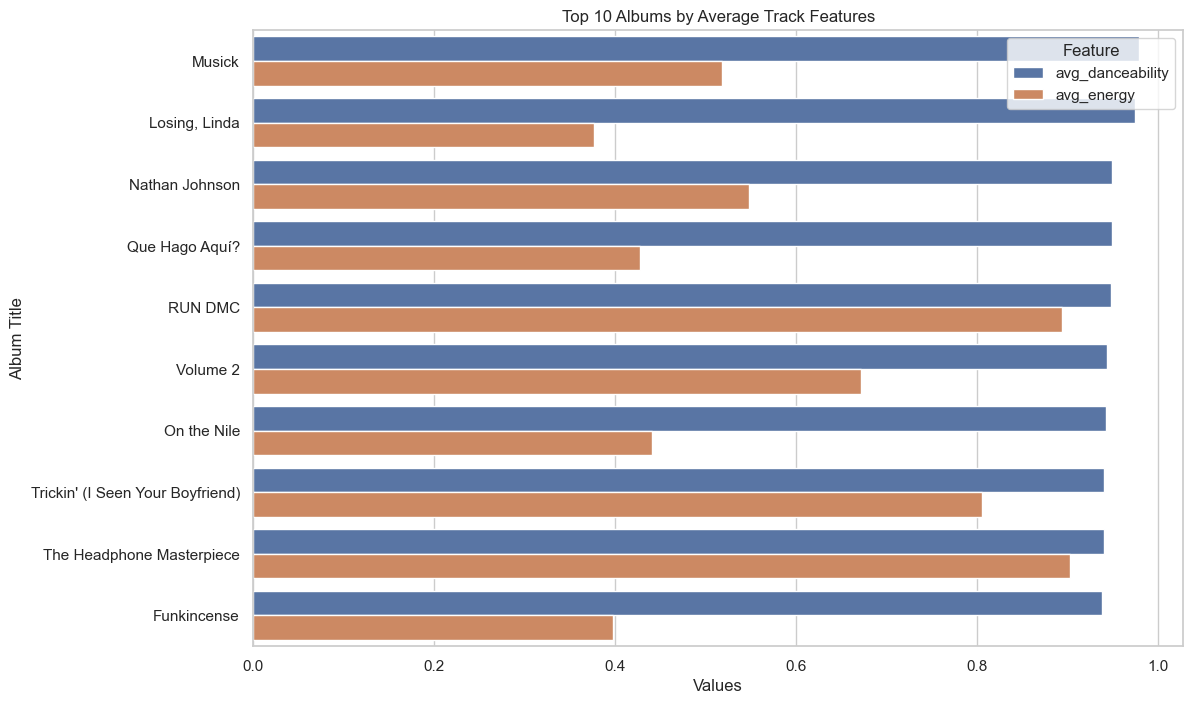

In [107]:
# 1. Average Track Features by Album
avg_features_data = run_query("""
SELECT albums.title as album_title, AVG(tracks.danceability) AS avg_danceability, 
AVG(tracks.energy) AS avg_energy
FROM tracks
JOIN albums ON tracks.album_id = albums.album_id
GROUP BY albums.title
ORDER BY avg_danceability DESC LIMIT 10;
""")

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
df_melted = avg_features_data.melt('album_title', var_name='Features', value_name='Values')
sns.barplot(x='Values', y='album_title', hue='Features', data=df_melted, ci=None)
plt.title('Top 10 Albums by Average Track Features')
plt.xlabel('Values')
plt.ylabel('Album Title')
plt.legend(title='Feature')
plt.show()


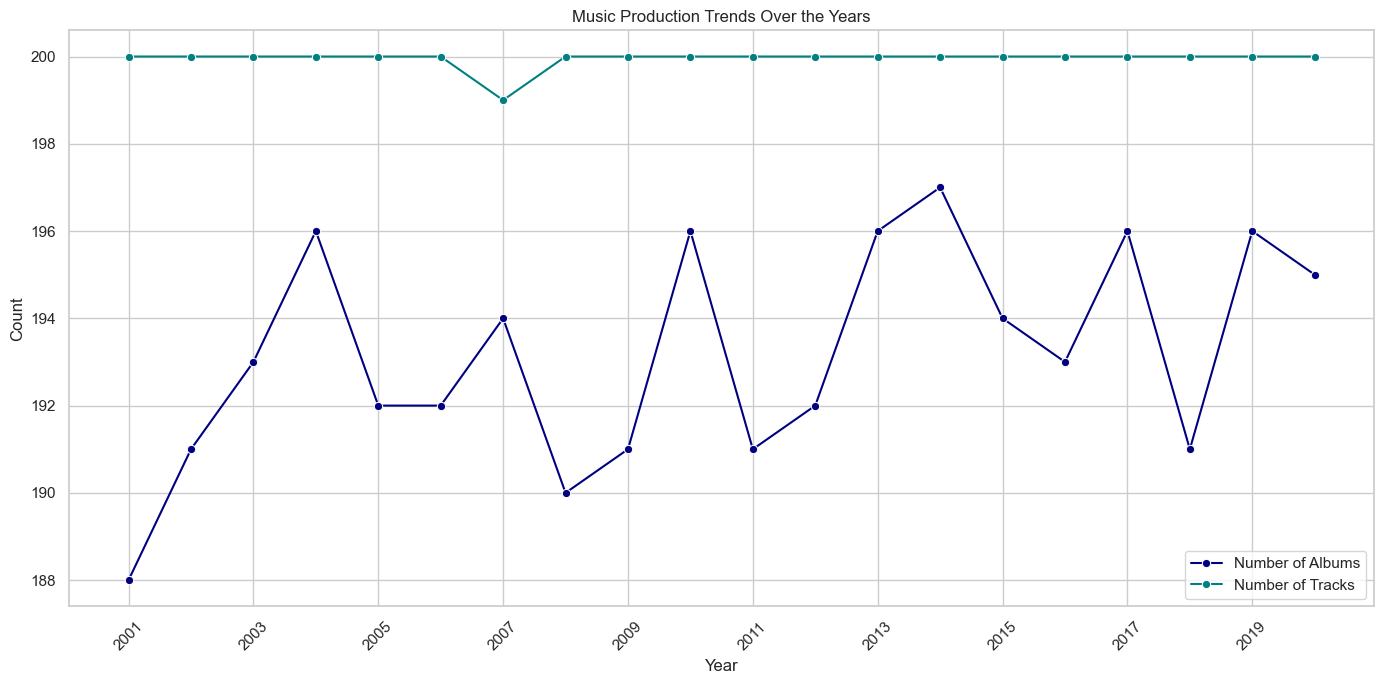

In [108]:
# 2. Count of Albums and Tracks per Year

# Execute the SQL query and fetch the data
production_trends_data = run_query("""
SELECT EXTRACT(YEAR FROM a.release_date) AS release_year,
       COUNT(DISTINCT a.album_id) AS num_albums,
       COUNT(t.track_id) AS num_tracks
FROM albums a
LEFT JOIN tracks t ON a.album_id = t.album_id
GROUP BY release_year
ORDER BY num_albums DESC LIMIT 20;
""")

plt.figure(figsize=(14, 7))
sns.lineplot(x='release_year', y='num_albums', data=production_trends_data, marker='o', label='Number of Albums', color='navy')
sns.lineplot(x='release_year', y='num_tracks', data=production_trends_data, marker='o', label='Number of Tracks', color='teal')

plt.title('Music Production Trends Over the Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.grid(True)

# Set x-ticks to be every year in the dataset if the range is small or for selected years if the range is large
if production_trends_data['release_year'].nunique() < 20:  # If fewer than 20 years, show all
    plt.xticks(production_trends_data['release_year'].unique(), rotation=45)
else:  # If many years, show every other year or customized intervals
    plt.xticks(np.arange(min(production_trends_data['release_year']), max(production_trends_data['release_year']) + 1, 2), rotation=45)

plt.tight_layout()
plt.show()



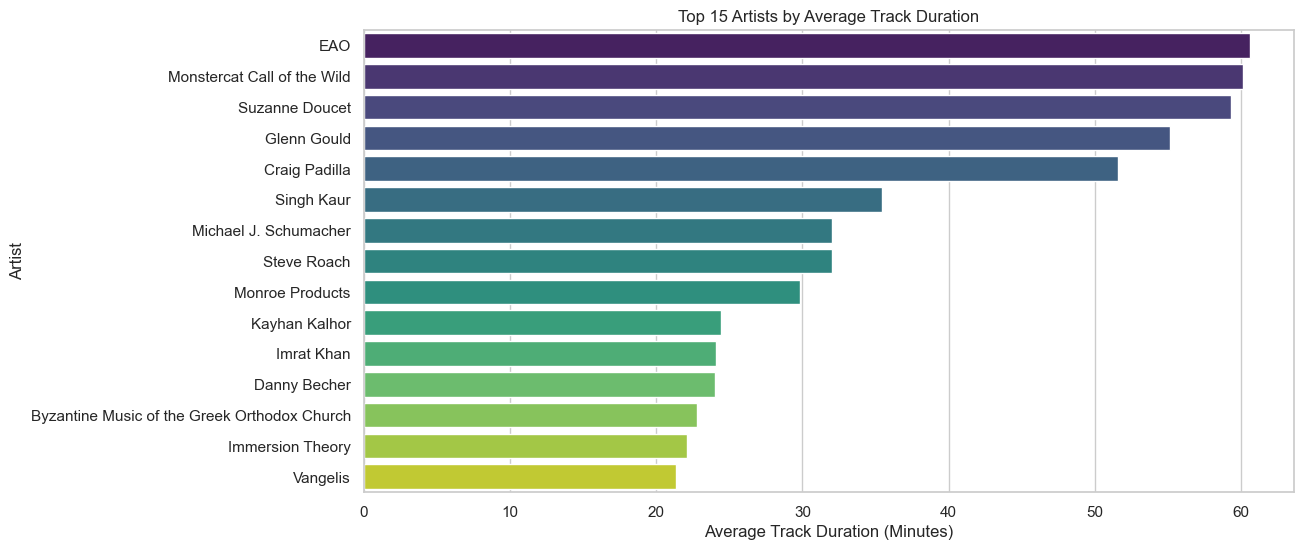

In [109]:
# 3. Average Track Duration by Artist
avg_duration_data = run_query("""
SELECT artists.name AS artist_name, AVG(tracks.duration_ms) / 60000 AS avg_duration_minutes
FROM artists
JOIN album_artist ON artists.artist_id = album_artist.artist_id
JOIN tracks ON album_artist.album_id = tracks.album_id
GROUP BY artists.name
ORDER BY avg_duration_minutes DESC LIMIT 15;
""")

plt.figure(figsize=(12, 6))
sns.barplot(x='avg_duration_minutes', y='artist_name', data=avg_duration_data, palette='viridis')
plt.title('Top 15 Artists by Average Track Duration')
plt.xlabel('Average Track Duration (Minutes)')
plt.ylabel('Artist')
plt.show()


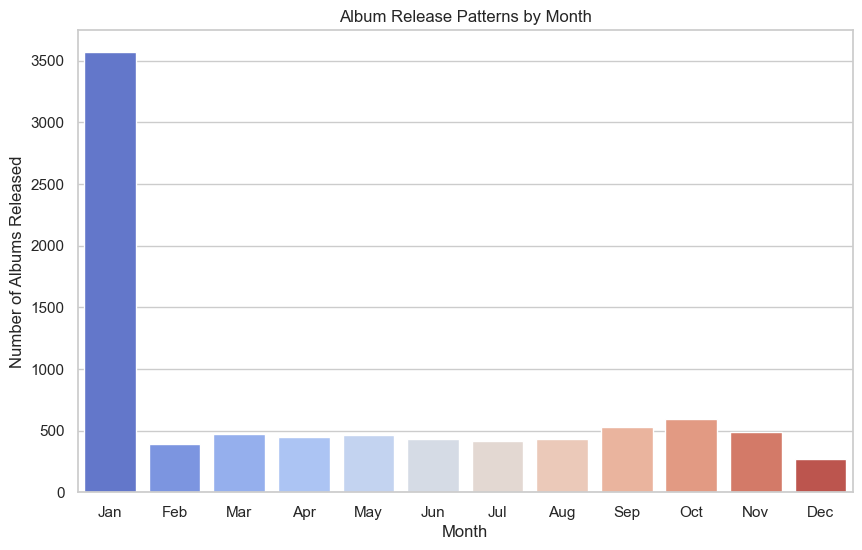

In [110]:
# 4. Album Release Patterns by Month
album_release_patterns_data = run_query("""
SELECT EXTRACT(MONTH FROM release_date) AS month, COUNT(*) AS num_albums
FROM albums
GROUP BY month
ORDER BY num_albums DESC LIMIT 12;
""")

# Mapping month numbers to month names for better readability
months = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
          7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
album_release_patterns_data['month_name'] = album_release_patterns_data['month'].map(months)

plt.figure(figsize=(10, 6))
sns.barplot(x='month_name', y='num_albums', data=album_release_patterns_data, palette='coolwarm', order=list(months.values()))
plt.title('Album Release Patterns by Month')
plt.xlabel('Month')
plt.ylabel('Number of Albums Released')
plt.show()


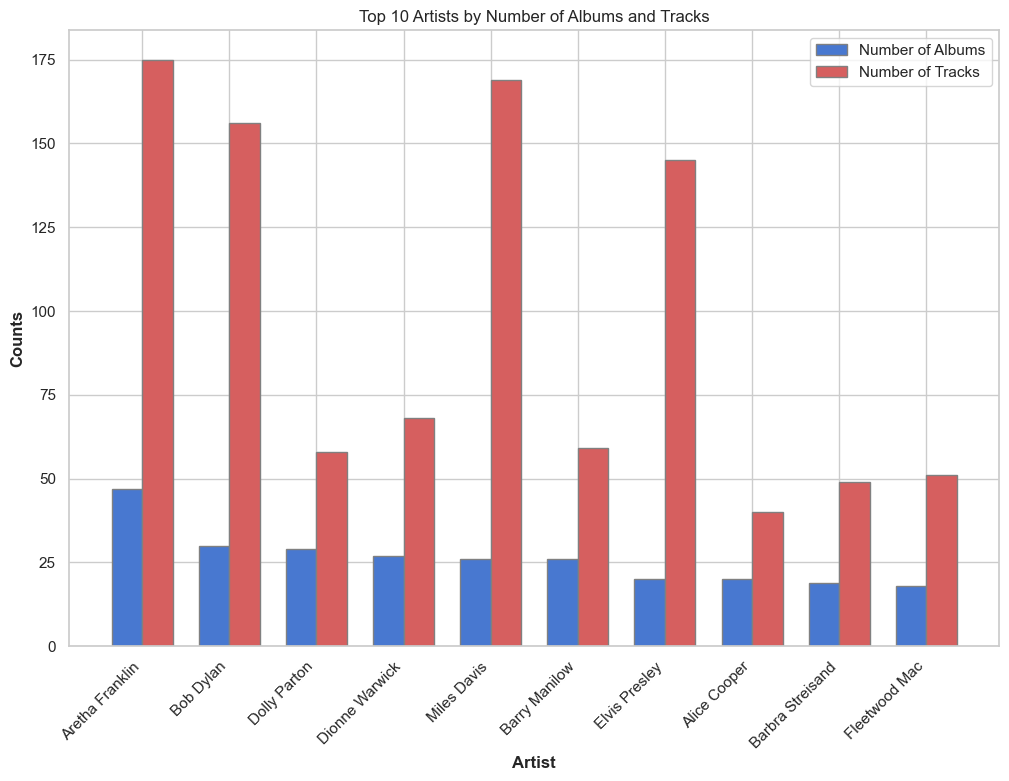

In [127]:
# 5. Detailed Artist Analysis
artist_analysis_data = run_query("""
SELECT artists.name, COUNT(DISTINCT albums.album_id) AS num_albums, COUNT(tracks.track_id) AS num_tracks
FROM artists
JOIN album_artist ON artists.artist_id = album_artist.artist_id
JOIN albums ON album_artist.album_id = albums.album_id
JOIN tracks ON albums.album_id = tracks.album_id
GROUP BY artists.name
ORDER BY num_albums DESC, num_tracks DESC LIMIT 10;
""")

# Plotting the results
fig, ax = plt.subplots(figsize=(12, 8))

# Define bar width. We'll need this to offset the second bar.
bar_width = 0.35

# Set position of bar on X axis
r1 = range(len(artist_analysis_data))
r2 = [x + bar_width for x in r1]

# Make the plot
plt.bar(r1, artist_analysis_data['num_albums'], color='b', width=bar_width, edgecolor='grey', label='Number of Albums')
plt.bar(r2, artist_analysis_data['num_tracks'], color='r', width=bar_width, edgecolor='grey', label='Number of Tracks')

# Add xticks on the middle of the group bars
plt.xlabel('Artist', fontweight='bold')
plt.ylabel('Counts', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(artist_analysis_data))], artist_analysis_data['name'], rotation=45, ha="right")

# Create legend & Show graphic
plt.legend()
plt.title('Top 10 Artists by Number of Albums and Tracks')
plt.show()